# $ Mariner \ Codes: $


### 1) Imports 

In [7]:
import numpy as np                          # for array manipulation
from matplotlib import pyplot as plt        # to plot images
from PIL import Image as im                 # to manipulate images
from random import randint as r             # to generate random numbers
from random import sample as s              # to generate random samples
from random import shuffle as sh            # to shuffle lists
from random import choice as c              # to choose randomly from a list
from itertools import product as p          # to construct cartesian products

### 2) Hadamard Matrix Generator

In [8]:
def hadamard_matrix(n):
    
    ''' This function takes in a natural number as input and returns the Hadamard matrix
        of order 2^n'''
    
    # Base case:    
    if n==0:
        return 1
    
    # Recursion:
    else:
        return np.vstack((np.hstack((hadamard_matrix(n-1), hadamard_matrix(n-1))),np.hstack((hadamard_matrix(n-1), -hadamard_matrix(n-1)))))

In [9]:
def construct_sublists(input_list, proportions):
    ''' This Function takes in a list of elements and a list of proportions then cuts the elements of this list
        respectively thus returning a list of lists containing the elements proportionaly '''
    
    total_elements = len(input_list)
    
    # Calculate the number of elements for each sublist based on proportions
    sublist_sizes = [int(prop * total_elements) for prop in proportions]
    
    # Ensure that the sum of sizes is equal to the length of the list
    sublist_sizes[-1] += total_elements - sum(sublist_sizes)
    
    # Create a list of unique indices
    indices = list(range(total_elements))
    
    # Shuffle the indices
    sh(indices)
    sh(input_list)
    
    # Use the sizes and shuffled indices to construct sublists without repetitions
    sublists = [input_list[i:i + size] for i, size in zip(range(0, total_elements, sublist_sizes[0]), sublist_sizes)]
    
    return sublists

### 3) Hadamard Code Generator

In [10]:
def hadamard_code(n):
    
    ''' This function takes in a non negative integer n and computes the hadamard matrix of
        dimension 2^n then returns a dictionnary enumerating they lines of the matrix which
        is exactly our Hadamard code assossiated to the Hadamard matrix '''
        
    # Constructing the Hadamard matrix:
    H = hadamard_matrix(n-1)
    H = np.vstack((H.copy(), -H.copy()))

    # Constructing the Hadamard code:
    Hadamard_Code = {}
    for i in range(0, pow(2, n)):
        Hadamard_Code[i] = H[i]
        
    return Hadamard_Code

In [11]:
def hadamard_decode(n):
    
    H = hadamard_matrix(n-1)
    H = np.vstack((H.copy(), -H.copy()))
    
    Hadamard_Code = {}

    for i in range(0, pow(2, n)):
        Hadamard_Code[str(list(H[i]))] = i
    
    return Hadamard_Code

### 4) Image Encoder

In [12]:
def image_encoder(image_path):
    
    ''' This function takes a string as input (image_path) which represents the path to the
    image we wish to encode using Hadamard coding technique and returns the Hadamard encoded
    picture's array '''
    
    Hadamard_code = hadamard_code(8) # Generating a Dictionary that maps all numbers from 0 to 255 (which constitutes the colors of a gray scaled image or the component colors of an RGB panel) to a unique line in the Hadamard matrix yielding the Hadamard code of colors
    
    image = im.open(image_path) # Opening the image

    if image.mode == 'L': # This case treats the gray scaled images
        
        image_array = np.array(image) # The array of the image
        coded_image_array = np.array([Hadamard_code[image_array[i, j]] for i in range(0, image_array.shape[0]) for j in range(0, image_array.shape[1])]) # Creating the array of the encoded image via a list of the image' entries as a hadamard coded vector
        coded_image_array = coded_image_array.reshape(image_array.shape[0], image_array.shape[1] * 128) # Reshaping the array to the original size of the image

        return coded_image_array
    
    else:
        
        R_array = np.array(image)[:, :, 0]
        G_array = np.array(image)[:, :, 1]
        B_array = np.array(image)[:, :, 2]
        
        arrays_list = [R_array, G_array, B_array]
        coded_arrays_list = []
        
        for array in arrays_list:
            
            coded_image_array = np.array([Hadamard_code[array[i, j]] for i in range(0, array.shape[0]) for j in range(0, array.shape[1])]) # Creating the array of the encoded image via a list of the image' entries as a hadamard coded vector
            coded_image_array = coded_image_array.reshape(array.shape[0], array.shape[1] * 128)
            coded_arrays_list.append(coded_image_array)
            
        return coded_arrays_list

### 5) Noise-Introducing Functions

#### 5) 1- Correctable noise-introducing function

In [13]:
def correction_type_error(coded_array, list_of_coordinates):
    
    ''' This function takes in 3 arguments and returns an array with some Correctable noise
    introduced in the respective places listed in the (list_of_coordinates) variable 
    
    1- coded_array: type = np_array. represents the array with its entries being the 
    hadamard coded colors of the original image ie vectors of the hadamard matrix each
    representing a particular color
    
    2- list_of_coordinates: type = list. represents a list of randomly generated tuples with
    entries ranging in the between the dimension of the image that is they represent coordinates
    of individual pixels in the image that will be perturbated in the transmition '''
    
    noised_coded_array = coded_array.copy() # Creating a copy of the given array    
    
    
    for coordinate in list_of_coordinates:
        number_of_bit_flip = r(1, 31) # Amount of noise introduced in an individual coded pixel
        index_of_noise = s(range(128), number_of_bit_flip) # A list containing the indexs of the elements to flip in a single coded pixel
        noised_coded_pixel_i = coordinate[0]
        noised_coded_pixel_j = coordinate[1] * 128
        noised_coded_pixel = coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128]  # Coded pixel to corrupt
        
        # Corruption of the coded_pixel by flipping its entries from 1 to -1 and conversly:
        for index in index_of_noise:
            if noised_coded_pixel[index] == 1:
                noised_coded_pixel[index] = -1
            else:
                noised_coded_pixel[index] = 1
        
        # Exchanging the image's coded pixel with the corrupted pixel:
        noised_coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128] = noised_coded_pixel
        
    return noised_coded_array

#### 5) 2- Detectable noise-introducing function

In [14]:
def detection_type_error(coded_array, list_of_coordinates):

    ''' This function takes in 2 arguments and returns an array with some Detectable noise
    introduced in the respective places listed in the (list_of_coordinates) variable 
    
    1- coded_array: type = np_array. represents the array with its entries representing the 
    hadamard coded colors of the original image
    
    2- list_of_coordinates: type = list. represents a list of randomly generated tuples with
    entries ranging in the between the dimension of the image that is they represent coordinates
    of individual pixels in the image that will be perturbated in the transmition '''
    
    noised_coded_array = coded_array.copy()
    
    for coordinate in list_of_coordinates:
        number_of_bit_flip = r(1, 63) # Amount of noise introduced in an individual coded pixel
        index_of_noise = s(range(128), number_of_bit_flip) # A list containing the indexs of the elements to flip in a single coded pixel
        noised_coded_pixel_i = coordinate[0]
        noised_coded_pixel_j = coordinate[1] * 128
        noised_coded_pixel = coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128]  # Coded pixel to corrupt
        
        #Corruption of the coded_pixel:
        for index in index_of_noise:
            if noised_coded_pixel[index] == 1:
                noised_coded_pixel[index] = -1
            else:
                noised_coded_pixel[index] = 1
        
        # Exchanging the image's coded pixel with the corrupted pixel:
        noised_coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128] = noised_coded_pixel
        
    return noised_coded_array

#### 5) 3- Lost information

In [15]:
def non_detectable_error(coded_array, list_of_coordinates):
    
    noised_coded_array = coded_array.copy()
    
    for coordinate in list_of_coordinates:
        number_of_bit_flip = r(64, 128) # Amount of noise introduced in an individual coded pixel
        
        if number_of_bit_flip == 128: # If the numbers of bits to flip is exactly the length of the code it means that we will flip all the vector's entries from 1 to -1 and conversly which is excatly the same as multiplying by -1
            noised_coded_pixel_i = coordinate[0]
            noised_coded_pixel_j = coordinate[1] * 128
            noised_coded_pixel = coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128]
            noised_coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128] = - noised_coded_pixel
            
        index_of_noise = s(range(128), number_of_bit_flip) # A list containing the indexs of the elements to flip in a single coded pixel
        noised_coded_pixel_i = coordinate[0]
        noised_coded_pixel_j = coordinate[1] * 128
        noised_coded_pixel = coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128]  # Coded pixel to corrupt
        
        #Corruption of the coded_pixel:
        for index in index_of_noise:
            if noised_coded_pixel[index] == 1:
                noised_coded_pixel[index] = -1
            else:
                noised_coded_pixel[index] = 1
        
        # Exchanging the image's coded pixel with the corrupted pixel:
        noised_coded_array[noised_coded_pixel_i, noised_coded_pixel_j : noised_coded_pixel_j + 128] = noised_coded_pixel
        
    return noised_coded_array    

### 5) 5- The noise function

In [16]:
def noise(color_coded_array, image_shape, noise_amount= .60, type_of_noise = "Mixed"):

    ''' This function takes in 3 arguments a color_coded_array, the amout of noise,
    length_of_code and type_of_noise
    
    1 - color_coded_array: type = numpy-array. represents the array of a color-coded gray-scaled
    image
    
    2 - image_shape: type = tupple. represents the shape of the image
    
    3 - noise amount: type = float. represents the amount of pixels that will be corrupted
    in the picture. the function generates as much random tupples with entries ranging in between
    the dimensions of the array and those represent the coordinates of the pixels that will be
    corrupted.
    
    4 - type_of_noise: type = str in {Correction, Detection, Mixed}. This parameter determines 
    the type of the noise that will be applied to the picture.
    
    *) Correction (default): for each of the coordinates of error placement it will generate a
    random number ranging between 1 and int(((dimH / 2) - 1) / 2 ) 
    
    *) Detection: for each of the coordinates of error placement it will generate a
    random number ranging between 1 and ((dimH / 2) - 1)
    
    *) Lost: for each of the coordinates of error placement it will generate a random
    number that is over the limit of detection creating a non detectable error hense
    loosing the information of the pixel
    
    *) Mixed:  for each of the coordinates of error placement, first makes a random choice 
    between "Detection" and "Correction" and "Lost" then applies the respective type of noise '''
    
    number_of_noised_pixels = int(image_shape[0]*image_shape[1]*noise_amount)
    
    # Generating a list of coordinates for pixels to be corrupted:
    coordinate_list = s(list(p(*[list(range(image_shape[0])), list(range(image_shape[1]))])), number_of_noised_pixels) # Creating a list of random tupples with entries ranging in the array's dimension

    # Introducing noise in the array:
    # Correction type:
    if type_of_noise == "Correction":
        return correction_type_error(color_coded_array, coordinate_list)
    
    # Detection type:
    elif type_of_noise == "Detection":
        return detection_type_error(color_coded_array, coordinate_list)
    
    # Lost information type:
    elif type_of_noise == "Lost":
        return non_detectable_error(color_coded_array, coordinate_list)
    
    # Mixed type:
    elif type_of_noise == "Mixed":
        
        while True:
            distribution = np.random.uniform(size=3)
            distribution /= np.sum(distribution)
            sublists = []
            try:
                sublists = construct_sublists(coordinate_list, distribution)
                if (len(sublists) == 2) or ([] in sublists):
                    next
                else:
                    break
            except (ValueError):
                next
                      
        correction_coordinate_list = sublists[0] # List of correction typed errors in the image
        detection_coordinate_list = sublists[1] # List of Detection typed errors in the image
        non_correctable_error = sublists[2] # List of non detectable errors in the image
        
        noised_array = correction_type_error(color_coded_array, correction_coordinate_list)
        noised_array = detection_type_error(noised_array, detection_coordinate_list)
        noised_array = non_detectable_error(noised_array, non_correctable_error)
        
        return [noised_array, correction_coordinate_list, detection_coordinate_list, non_correctable_error]

#### 6) Decoder

In [17]:
def decoder(color_coded_array, image_shape, H_code, codes):
        
    computing_array = color_coded_array.copy()
    computing_array = computing_array.reshape(image_shape[0]*image_shape[1], 128)
    
    decoded_vectors_list = []
    for i in range(0, computing_array.shape[0]):
        received_vector = computing_array[i]
        
        if list(received_vector) in codes:
            decoded_vectors_list.append(H_code[str(list(received_vector))])
        
        else:
            distances_dictionary = dict([(str(index), list(np.array(index) + received_vector).count(0)) for index in codes])
            min_distance = min(distances_dictionary.values())
            
            if min_distance <= 31:
                min_vector = [vector for vector in list(distances_dictionary.keys()) if distances_dictionary[vector] == min_distance][0]
                decoded_vectors_list.append(H_code[min_vector])
                
            elif 32 <= min_distance <= 63:
                list_of_possibilities = [vectors for vectors in list(distances_dictionary.keys()) if distances_dictionary[vectors] == min_distance]
                decoded_vector = c(list_of_possibilities)
                decoded_vectors_list.append(H_code[decoded_vector])
            
            else:
                decoded_vectors_list.append(r(0, 255))
                
    decoded_array = np.array(decoded_vectors_list)
    decoded_array = decoded_array.reshape(color_coded_array.shape[0], color_coded_array.shape[1] // 128)
    
    return decoded_array

In [18]:
def display_error_in_image(path_to_image, list_of_errors):
    
    image = im.open(path_to_image)
    image_array = np.array(image)

    for coordinate in list_of_errors[0]:
        image_array[coordinate[0], coordinate[1]] = 255
    
    for coordinate in list_of_errors[1]:
        image_array[coordinate[0], coordinate[1]] = 127
    
    for coordinate in list_of_errors[2]:
        image_array[coordinate[0], coordinate[1]] = 0
    
    return image_array

In [19]:
import cv2

def circle_error_in_image(path_to_image, list_of_errors):
    image = cv2.imread(path_to_image)

    # Define the pixel coordinates where you want to draw the circle
    center_corectable_coordinates = list_of_errors[0][:50]  # Example coordinates (row, column)
    center_detectable_coordinates = list_of_errors[1][:50]
    center_lost_coordinates = list_of_errors[2][:50]
    
    # Draw the circle on the image
    for coordinates in center_corectable_coordinates:
        cv2.circle(image, coordinates, 10, (0, 255, 0), thickness=2)
    
    for coordinates in center_detectable_coordinates:
        cv2.circle(image, coordinates, 10, (255, 165, 0), thickness=2)
        
    for coordinates in center_lost_coordinates:
        cv2.circle(image, coordinates, 10, (255, 0, 0), thickness=2)    
    
    # Display the image with the circle
    return np.array(image)

# Testing:

#### 1) Testing grayscaled images:

(550, 600)


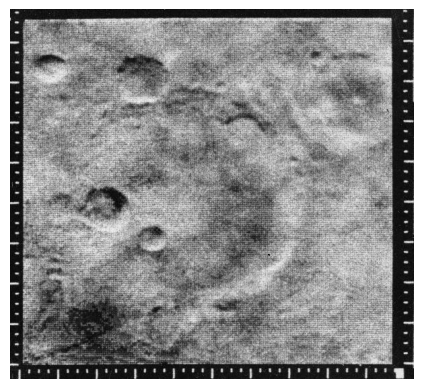

In [20]:
# Opening the image

image_array1 = np.array(im.open("Mariner 4.jpg"))
print(image_array1.shape)

image = cv2.imread("Mariner 4.jpg", cv2.IMREAD_GRAYSCALE)


plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [21]:
# Encoding the image:

encoded_image_array = image_encoder("Mariner 4.jpg")

In [22]:
# Noising the image:

noised_image_array = noise(encoded_image_array, (550, 600), .5)

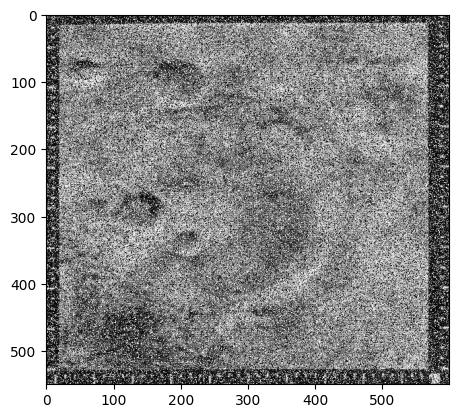

In [25]:
# Displaying the noisy picture

plt.imshow(display_error_in_image("Mariner 4.jpg", noised_image_array[1:]), cmap='gray')

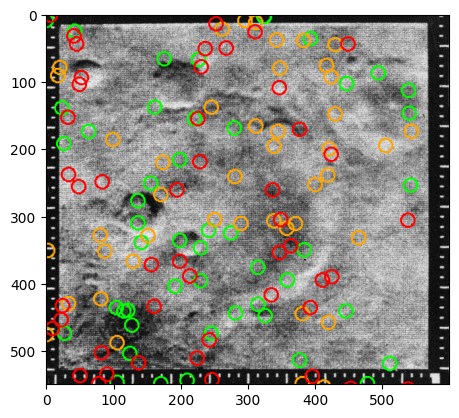

In [26]:
# Circling some places where the picture were altered

plt.imshow(circle_error_in_image("Mariner 4.jpg", noised_image_array[1:]))

In [49]:
# Decoding the image:

H_code = hadamard_decode(8)
codes = [eval(code) for code in list(H_code.keys())]

decoded_image_array = decoder(noised_image_array[0], (550, 600), H_code, codes) 

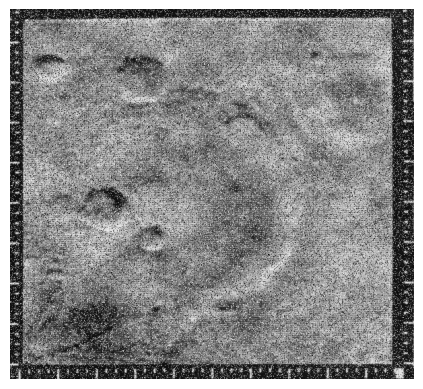

In [50]:
# Displaying the decoded image

plt.imshow(decoded_image_array, cmap='gray')
plt.axis('off')
plt.show()

#### 2) Testing Colored Images:

(275, 213, 3)


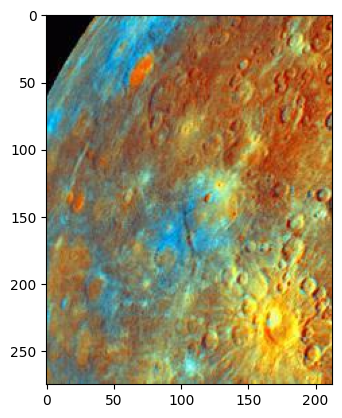

In [33]:
# Opening image, Dicecting it and plotting:

image_array1 = np.array(im.open("Mariner 10.jpg"))

print(image_array1.shape)

Red = image_array1[:, :, 0]
Green = image_array1[:, :, 1]
Blue = image_array1[:, :, 2]

imm = np.stack([Red, Green, Blue], axis= -1)
plt.imshow(imm)

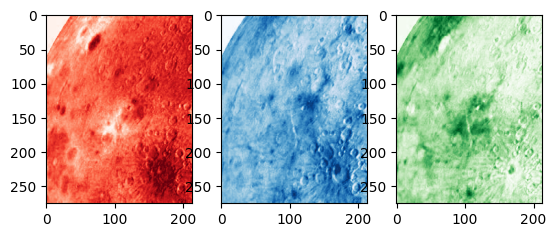

In [17]:
# Plotting all 3 layers:

plt.subplot(1, 3, 1)
plt.imshow(Red, cmap='Reds', vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.imshow(Green, cmap='Blues', vmin=0, vmax=255)
plt.subplot(1, 3, 3)
plt.imshow(Blue, cmap='Greens', vmin=0, vmax=255)

In [18]:
# Encoding all 3 layers:
image_array = image_encoder("Mariner 10.jpg")

In [19]:
# Noising the layers:

noised_Red_list = noise(image_array[0], (275, 213), .3)
noised_Green_list = noise(image_array[1], (275, 213), .3)
noised_Blue_list = noise(image_array[2], (275, 213), .3)

Text(0.5, 1.0, 'Corrupted Blue Layer')

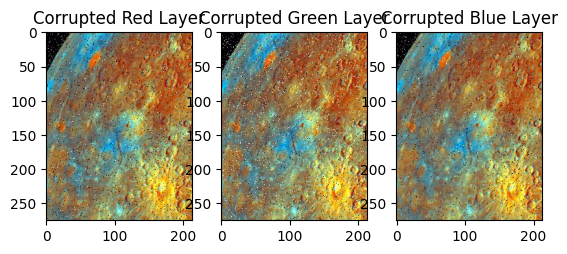

In [20]:
# Plotting the noised layers:

plt.subplot(1, 3, 1)
plt.imshow(display_error_in_image("Mariner 10.jpg", noised_Red_list[1:]))
plt.subplot(1, 3, 2)
plt.imshow(display_error_in_image("Mariner 10.jpg", noised_Green_list[1:]))
plt.subplot(1, 3, 3)
plt.imshow(display_error_in_image("Mariner 10.jpg", noised_Blue_list[1:]))

In [131]:
# Decoding Layers (Carefull might take a lot of time and consume a lot of resources)

H_code = hadamard_decode(8)
codes = [eval(code) for code in list(H_code.keys())]

decoded_Red_array = decoder(noised_Red_list[0], (275, 213), H_code, codes)
decoded_Green_array = decoder(noised_Green_list[0], (275, 213), H_code, codes)
decoded_Blue_array = decoder(noised_Blue_list[0], (275, 213), H_code, codes)

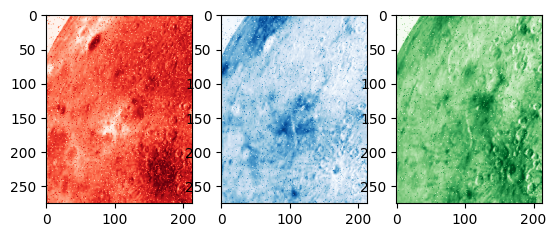

In [134]:
# Plotting the received Layers

plt.subplot(1, 3, 1)
plt.imshow(decoded_Red_array, cmap='Reds', vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.imshow(decoded_Blue_array, cmap='Blues', vmin=0, vmax=255)
plt.subplot(1, 3, 3)
plt.imshow(decoded_Green_array, cmap='Greens', vmin=0, vmax=255)

In [21]:
# Percentage of the picture that had been lost

R = Red == decoded_Red_array
G = Green == decoded_Green_array
B = Blue == decoded_Blue_array

print((np.count_nonzero(np.logical_not(R))*100) / (275*213*3))
print((np.count_nonzero(np.logical_not(G))*100) / (275*213*3))
print((np.count_nonzero(np.logical_not(B))*100) / (275*213*3))

NameError: name 'decoded_Red_array' is not defined

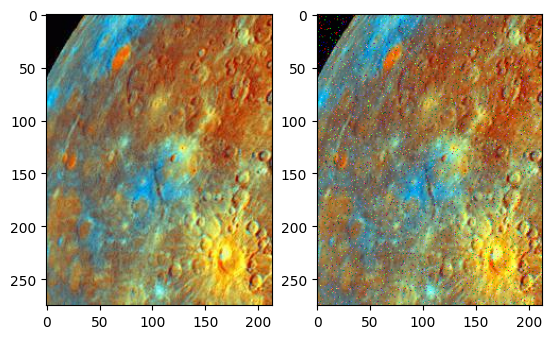

In [138]:
# Reconstructing the image and plotting it asside the original one

decoded_image_array = np.stack([decoded_Red_array, decoded_Green_array,decoded_Blue_array], axis=-1) 

plt.subplot(1, 2, 1)
plt.imshow(image_array1)
plt.subplot(1, 2, 2)
plt.imshow(decoded_image_array)